In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn import preprocessing

In [2]:
df= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
df.columns

Index(['location', 'tcode', 'mcode', 'store', 'ucode', 'workid', 'sn',
       'crew_size', 'labor_hours', 'start_time', 'stop_time', 'categ', 'month',
       'day', 'year', 'weekday', 'kfold'],
      dtype='object')

In [4]:
test.columns

Index(['location', 'tcode', 'mcode', 'store', 'ucode', 'workid', 'sn',
       'crew_size', 'labor_hours', 'start_time', 'stop_time', 'categ', 'month',
       'day', 'year', 'weekday'],
      dtype='object')

In [5]:
test.isnull().sum()

location       0
tcode          0
mcode          0
store          0
ucode          0
workid         0
sn             0
crew_size      0
labor_hours    0
start_time     0
stop_time      0
categ          0
month          0
day            0
year           0
weekday        0
dtype: int64

In [6]:
def preprocess(df):
    col=['location', 'tcode', 'mcode', 'store', 'ucode', 'workid', 'sn',
        'categ', 'month',
       'day', 'year', 'weekday']
    
    #below has no intrinsic numerical value therefore convert to type object(str)
    for i in col:
        df[i]=df[i].astype(str)
        
#     df['location']=df['location'].astype('category')
#     df['tcode']=df['tcode'].astype('category')
#     df['mcode']=df['mcode'].astype('category')
#     df['store']=df['store'].astype('category')
#     df['ucode']=df['ucode'].astype('category')
#     df['workid']=df['workid'].astype('category')
#     df['sn']=df['sn'].astype('category')
#     df['categ']=df['categ'].astype('category')
#     df['month']=df['month'].astype('category')
#     df['day']=df['day'].astype('category')
#     df['year']=df['year'].astype('category')
    
   
    
    
    return df


df = preprocess(df)
test=preprocess(test)

    

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109443 entries, 0 to 109442
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   location     109443 non-null  object 
 1   tcode        109443 non-null  object 
 2   mcode        109443 non-null  object 
 3   store        109443 non-null  object 
 4   ucode        109443 non-null  object 
 5   workid       109443 non-null  object 
 6   sn           109443 non-null  object 
 7   crew_size    109443 non-null  int64  
 8   labor_hours  109443 non-null  float64
 9   start_time   109443 non-null  float64
 10  stop_time    109443 non-null  float64
 11  categ        109443 non-null  object 
 12  month        109443 non-null  object 
 13  day          109443 non-null  object 
 14  year         109443 non-null  object 
 15  weekday      109443 non-null  object 
dtypes: float64(3), int64(1), object(12)
memory usage: 13.4+ MB


In [8]:
object_cols =[i for i in df.columns if df[i].dtypes == 'O']
#numerical_cols=[i for i in df_train.columns if df_train[i].dtypes != 'O' and i not in ("labor_hours","kfold") ]
useful_features = [i for i in df.columns if i not in ("labor_hours","kfold")]
df_test =test[useful_features]


In [9]:
ytest = test.labor_hours

In [10]:
df_test

,location,tcode,mcode,store,ucode,workid,sn,crew_size,start_time,stop_time,categ,month,day,year,weekday
0,583,84.0,1124.0,64,1511,215560,1,3,17.00,19.50,15,11,7,2017,Tuesday
1,495,88.0,1048.0,80,4286,270697,13,1,12.00,19.00,15,1,7,2020,Tuesday
2,10225,76.0,504.0,49,762,196097,1,3,16.00,17.00,15,2,21,2017,Tuesday
3,270,88.0,1048.0,27,51,208347,1,3,13.00,18.00,15,7,19,2017,Wednesday
4,6226,71.0,999.0,56,3526,1141,1,1,21.06,21.39,15,6,3,2011,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109438,398,76.0,1055.0,19,985,153281,2,2,15.50,16.10,1,6,15,2015,Monday
109439,733,88.0,1048.0,64,73,249193,2,2,19.15,19.30,15,2,22,2019,Friday
109440,9258,88.0,1048.0,45,764,168038,1,2,22.15,22.30,15,1,12,2016,Tuesday
109441,541,88.0,1048.0,80,4334,295548,25,1,12.00,14.00,15,11,25,2020,Wednesday


In [ ]:
temp_df = []
temp_test_feat = None
for col in object_cols:
    
    for fold in range(5):
        
        xtrain =  df[df.kfold != fold].reset_index(drop=True)#the rest of data that is not the current fold
        xvalid = df[df.kfold == fold].reset_index(drop=True) #data in current fold
        
        #within each xtrain columns you group by its values and get corresponding mean of labor_hours 
        feat = xtrain.groupby(col)["labor_hours"].agg("mean")
        feat = feat.to_dict()
      
        #map those values to corresponding feat dict in xvalid dataset
        xvalid.loc[:, f"tar_enc_{col}"] = xvalid[col].map(feat)
        #add it onto the temporary dataframe
        temp_df.append(xvalid)
        
        if temp_test_feat is None:
            temp_test_feat = df_test[col].map(feat)
        else:
            temp_test_feat += df_test[col].map(feat)
    
    #since there is five fold, we take the mean of the target encoding
    temp_test_feat /= 5
    #locate the col value and map the correspoinded encoded value for the test set.
    df_test.loc[:, f"tar_enc_{col}"] = temp_test_feat
    df = pd.concat(temp_df)

In [17]:
df_test.drop(object_cols, axis=1, inplace=True)
df_test

,crew_size,start_time,stop_time,tar_enc_location,tar_enc_tcode,tar_enc_mcode,tar_enc_store,tar_enc_ucode,tar_enc_workid,tar_enc_sn,tar_enc_categ,tar_enc_month,tar_enc_day,tar_enc_year,tar_enc_weekday
0,3,16.00,18.00,3.876185,4.754989,5.151841,12.250498,8.892816,12.738189,9.528240,7.665500,7.165085,7.343034,5.625060,7.075784
1,5,21.00,23.00,7.879566,7.954564,7.664809,10.191972,12.380465,14.123520,11.775685,8.114989,7.460507,7.014159,7.749756,7.435558
2,1,15.30,15.35,6.990317,7.776714,7.629239,5.172899,4.069506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,18.45,22.15,12.829451,7.596875,7.370447,14.094513,10.292763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,14.00,15.00,4.239063,6.537464,7.736603,5.989670,2.585586,3.117117,5.711119,6.902076,7.242709,7.238308,7.168414,7.319290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109438,3,16.20,16.40,5.811071,7.540865,7.582069,7.435555,4.522037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109439,2,15.50,16.00,1.349526,6.648556,7.403607,2.980738,1.993488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109440,1,14.00,14.01,5.487678,2.164060,4.633655,3.713166,1.942994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109441,2,16.00,17.00,5.659740,6.162932,7.013806,9.659756,5.605322,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_test

,location,tcode,mcode,store,ucode,workid,sn,crew_size,start_time,stop_time,...,tar_enc_mcode,tar_enc_store,tar_enc_ucode,tar_enc_workid,tar_enc_sn,tar_enc_categ,tar_enc_month,tar_enc_day,tar_enc_year,tar_enc_weekday
0,776,72.0,1048.0,80,1788,225766,35,3,16.00,18.00,...,5.151841,12.250498,8.892816,12.738189,9.528240,7.665500,7.165085,7.343034,5.625060,7.075784
1,6992,nan,nan,34,4,116079,20,5,21.00,23.00,...,7.664809,10.191972,12.380465,14.123520,11.775685,8.114989,7.460507,7.014159,7.749756,7.435558
2,2945,nan,nan,55,7,112829,1,1,15.30,15.35,...,7.629239,5.172899,4.069506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,329,71.0,1149.0,27,3872,60246,1,2,18.45,22.15,...,7.370447,14.094513,10.292763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,698,82.0,1053.0,64,536,95818,1,2,14.00,15.00,...,7.736603,5.989670,2.585586,3.117117,5.711119,6.902076,7.242709,7.238308,7.168414,7.319290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109438,9040,nan,nan,28,7,25241,1,3,16.20,16.40,...,7.582069,7.435555,4.522037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109439,11106,nan,nan,45,15,225090,1,2,15.50,16.00,...,7.403607,2.980738,1.993488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109440,377,69.0,1048.0,19,2909,174445,1,1,14.00,14.01,...,4.633655,3.713166,1.942994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109441,3266,71.0,354.0,58,924,144270,1,2,16.00,17.00,...,7.013806,9.659756,5.605322,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df

,location,tcode,mcode,store,ucode,workid,sn,crew_size,labor_hours,start_time,...,tar_enc_mcode,tar_enc_store,tar_enc_ucode,tar_enc_workid,tar_enc_sn,tar_enc_categ,tar_enc_month,tar_enc_day,tar_enc_year,tar_enc_weekday
0,345,nan,nan,27,51,43513,1,3,24.0,15.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6735,nan,nan,59,25,17758,1,2,20.0,11.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,552,88.0,1048.0,72,140,229408,1,1,0.1,14.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7239,nan,nan,34,4,111748,5,5,6.6,4.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,822,82.0,1053.0,64,536,204502,1,2,1.0,15.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87548,268,nan,nan,27,51,75910,1,3,24.0,13.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501926
87549,10534,nan,nan,72,73,77075,5,2,10.0,16.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501926
87550,10229,72.0,1048.0,49,800,150732,1,2,1.0,15.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.949284
87551,847,71.0,319.0,64,4000,233301,1,2,0.3,17.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.949284


In [12]:
df.drop(object_cols, axis=1, inplace=True)
df


,crew_size,labor_hours,start_time,stop_time,kfold,tar_enc_location,tar_enc_tcode,tar_enc_mcode,tar_enc_store,tar_enc_ucode,tar_enc_workid,tar_enc_sn,tar_enc_categ,tar_enc_month,tar_enc_day,tar_enc_year,tar_enc_weekday
0,3,24.0,15.00,23.00,0,7.629490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20.0,11.00,21.00,0,6.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.1,14.00,14.01,0,4.521671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,6.6,4.40,5.59,0,7.297500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1.0,15.00,15.30,0,4.726357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87548,3,24.0,13.00,21.00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501926
87549,2,10.0,16.00,21.00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501926
87550,2,1.0,15.31,16.00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.949284
87551,2,0.3,17.30,17.40,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.949284


In [36]:
df.tar_enc_store.value_counts().sort_index(ascending=False)

35.221127     51
34.651628     49
34.220093     50
34.089163     61
33.843602     53
            ... 
0.194034      76
0.168678      80
0.153016     113
0.100000       6
0.100000       6
Name: tar_enc_store, Length: 365, dtype: int64

In [15]:
useful_features = [i for i in df.columns if i not in ("labor_hours","kfold")]
useful_features

['crew_size',
 'start_time',
 'stop_time',
 'tar_enc_location',
 'tar_enc_tcode',
 'tar_enc_mcode',
 'tar_enc_store',
 'tar_enc_ucode',
 'tar_enc_workid',
 'tar_enc_sn',
 'tar_enc_categ',
 'tar_enc_month',
 'tar_enc_day',
 'tar_enc_year',
 'tar_enc_weekday']

In [20]:
final_predictions = []
scores = []
for fold in range(5):
    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()

    ytrain = xtrain.labor_hours
    yvalid = xvalid.labor_hours
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
#     ordinal_encoder = preprocessing.OrdinalEncoder()
#     xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
#     xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
#     xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])
    model = XGBRegressor(random_state=fold, n_jobs=4)
    model.fit(xtrain, ytrain)
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_predictions.append(test_preds)
    rmse = mean_squared_error(yvalid, preds_valid, squared=False)
    print(fold,rmse)
    scores.append (rmse)
    print(np.mean(scores), np.std(scores))

0 0.9504869346570589
0.9504869346570589 0.0
1 0.8393118583101158
0.8948993964835874 0.05558753817347156
2 0.7914778607215862
0.860425551229587 0.06660987124031718
3 0.8000584408413371
0.8453337736325245 0.06333199399281783
4 0.831049715149521
0.8424769619359237 0.05693328255743199


In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score, mean_squared_error

def print_metrics(y, preds):
    print("R2 Score: {:.4f}".format(r2_score(y, preds) * 100))
    print("Explained variance score: {:.4f}".format(explained_variance_score(y, preds) * 100))
    print("Mean absolute error: {:.4f}".format(mean_absolute_error(y, preds)))
    print("Root mean squared error: {:.4f}".format(mean_squared_error(y, preds, squared=False)))

In [24]:
print_metrics(ytest, test_preds)

R2 Score: 99.2455
Explained variance score: 99.2466
Mean absolute error: 0.3667
Root mean squared error: 0.9120


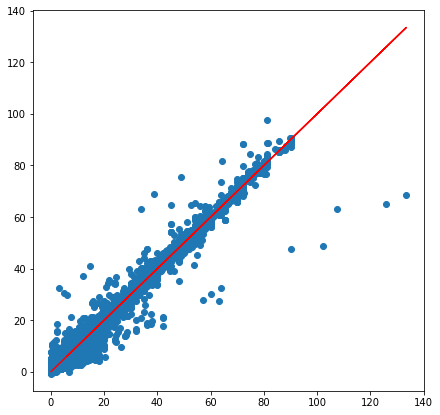

In [41]:
plt.figure(figsize=(7, 7))
plt.scatter(ytest, test_preds)
plt.plot(ytest, ytest, color='red');

In [31]:
xtrain.tar_enc_day.value_counts()

5.889255    3273
6.049800    3225
5.807318    3200
6.088459    3188
5.294172    3169
            ... 
5.778312    2265
5.908170    1327
6.125428    1299
6.089212    1280
5.961064    1237
Name: tar_enc_day, Length: 124, dtype: int64

In [ ]:
xtrain

In [39]:
df = df.reset_index()

In [44]:
# from sklearn.linear_model import Ridge
# from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

final_predictions = []
scores = []
for fold in range(5):
    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()

    ytrain = xtrain.labor_hours
    yvalid = xvalid.labor_hours
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    

    model = sm.OLS(ytrain, sm.add_constant(xtrain))
    fit = model.fit()
    fit.summary()
    break
   

    
#     scaler = StandardScaler()

#     X_train_scaled = scaler.fit_transform(xtrain.values)
#     X_val_scaled = scaler.transform(xvalid.values)
#     X_test_scaled = scaler.transform(xtest.values)

    
#     ordinal_encoder = preprocessing.OrdinalEncoder()
#     xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
#     xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
#     xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])


#     model = Ridge(alpha = 1.0)
#     model.fit(xtrain, ytrain)
#     valid_preds = model.predict(xvalid)
#     test_preds = model.predict(xtest)
#     final_predictions.append(test_preds)
#     rmse = mean_squared_error(yvalid, valid_preds, squared=False)
#     print(fold,rmse)
#     scores.append (rmse)
#     print(np.mean(scores), np.std(scores))

/Users/yongalhamo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


MissingDataError: exog contains inf or nans